# DE as a Global Optimizer

In this notebook, we shall use DE on a toy function to find the global optimum. The goal of this notebook is to introduce to the reader how any function can be interfaced with DE from [DE-NAS](https://github.com/automl/DE-NAS).

In [1]:
# Importing DE and ensuring dependencies are in place

from denas import DE

### Toy function

The _eggholder_ function from [Scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#global-optimization) will be the black-box function to be optimised.

In [2]:
import numpy as np
seed = 0
np.random.seed(0)


def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47)))) - \
            x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

bounds = [(-512, 512), (-512, 512)]

This is a 2-dimensional function that looks like an egg carton and has many local minima.

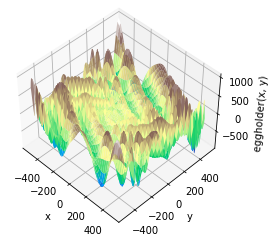

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')

plt.show()

### Generating random samples and evaluating eggholder

We can sample any number of points from the specified bounds for the function and query the function to get an objective value.

In [4]:
def random_samples_2d(size, bounds):
    sample_x = np.random.uniform(low=bounds[0][0], high=bounds[0][1], size=size)
    sample_y = np.random.uniform(low=bounds[1][0], high=bounds[1][1], size=size)
    samples = [[sample_x[i], sample_y[i]] for i in range(size)]
    return samples

samples = random_samples_2d(5, bounds)

In [5]:
for sample in samples:
    print("Sample: {}; Eggholder: {}".format(sample, eggholder(sample)))

Sample: [49.98502802158055, 149.39557178025586]; Eggholder: -122.29896515986395
Sample: [220.35391116535754, -63.91069566700287]; Eggholder: -69.97899856681124
Sample: [105.22969709736333, 401.1755528008497]; Eggholder: 203.40350689047187
Sample: [45.96037938882239, 474.790666753054]; Eggholder: 500.9089064263167
Sample: [-78.17748547696158, -119.35588472240363]; Eggholder: -13.43594125101697


###  DE search space and custom objective function

The search space for DE is scaled to [0,1] for all the dimensions. Hence, DE's stochastic vector operations are uniformly scaled in the unit hypercube and maintains parity for all dimensions across optimisation runs. <br>

To ensure this, we can either create a sampler that samples from this unit hypercube, that DE can directly work on. Or sample from the original space of the function, normalize it to the [0,1] space. Given that DE is seeded with random samples only at the beginning, we leave this choice of bounds for sampling to the user. In this example, we shall use DE's [_init\_population_](https://github.com/automl/DE-NAS/blob/master/denas/optimizers/de.py#L48) already defined to sample from the unit hypercube. <br>

The key is to have a rescaling operation inside the objective function that is to be defined and passed to DE during initialisation, as the function to optimize. As can be seen from the default objective function design, [_f\_objective_](https://github.com/automl/DE-NAS/blob/master/denas/optimizers/de.py#L161), the function needs only the input x and an optional budget, and returns a tuple of the evaluation (fitness) and the corresponding cost to evaluate the input. Since DE works on one fidelity level, we shall ignore the budget parameter while defining the objective function.

In [6]:
import time

def eggholder_objective(x):
    '''Evaluates x on the eggholder function (minimizing)
    
    x: a list/array of length 2 with each value in [0, 1]
    '''
    start = time.time()
    bound_range = [bounds[0][1] - bounds[0][0]]
    bound_range.append(bounds[1][1] - bounds[1][0])
    bound_min = [bounds[0][0]]
    bound_min.append(bounds[1][0])
    x_new = x.copy()
    for i in range(len(x)):
        x_new[i] = bound_min[i] + x[i] * bound_range[i]
    
    # the fitness which determines the selection process in DE
    ## the lower the fitness value, the better is x adjudged to be
    fitness = eggholder(x_new)
    # runtime of objective, or None, or equivalent
    cost = time.time() - start 
    
    return fitness, cost

### Initialising and running DE

In [7]:
de = DE(
    dimensions=len(bounds),
    configspace=False,  # if passing a custom search space and not ConfigSpace
    f=eggholder_objective,  # passing the objective function
    pop_size=20,  # tunable hyperparameter (minimum limit determined by mutation strategy)
    mutation_factor=0.5,  # tunable hyperparameter (determines exploration)
    crossover_prob=0.5,  # tunable hyperparameter (determines exploitation)
    strategy='rand1_bin',  # tunable hyperparameter (trades-off exploration-exploitation)
)

We just initialised the classical DE version to optimize the _eggholder_ function. DE iterations are called _generations_ here. In each generation, all the _pop\_size_ individuals in the population is put through a DE evolution: mutation -> crossover -> selection. Where the selection process determines if that individual will be retained or replaced with the new individual. <br>

While setting the iterations for DE, we need to be aware of the number of function evaluations that will take place: _generations_ times _pop\_size_. For this example, we shall run 100 generations of DE which means a total of 2000 function evaluations for a population size of 20.

In [8]:
trajectory, runtime, history = de.run(generations=10, verbose=True)

Initializing and evaluating new population...
Running evolutionary search...
Generation 1 /10 -- -547.8635
Generation 2 /10 -- -547.8635
Generation 3 /10 -- -547.8635
Generation 4 /10 -- -553.7958
Generation 5 /10 -- -632.2699
Generation 6 /10 -- -632.2699
Generation 7 /10 -- -632.2699
Generation 8 /10 -- -632.2699
Generation 9 /10 -- -632.2699
Generation 10/10 -- -632.2699

Run complete!


In [9]:
# To continue the optimisation for another 10 generations

trajectory, runtime, history = de.run(
    generations=10, 
    verbose=True, 
    reset=False   # default is 'True', but setting 'False' allows resuming
)

Running evolutionary search...
Generation 1 /10 -- -632.2699
Generation 2 /10 -- -632.2699
Generation 3 /10 -- -632.5996
Generation 4 /10 -- -632.5996
Generation 5 /10 -- -632.5996
Generation 6 /10 -- -693.6409
Generation 7 /10 -- -760.9905
Generation 8 /10 -- -760.9905
Generation 9 /10 -- -832.5399
Generation 10/10 -- -832.5399

Run complete!


In [10]:
# now restarting the DE optimisation and running 1000 generations

trajectory, runtime, history = de.run(generations=1000, verbose=False, reset=True)
print(trajectory[-1])

-956.9182316246659


In [11]:
# verifying number of samples evaluated

generations_run = 1000
pop_size = 20
print(len(trajectory))  # pop_size + pop_size * generations
print(len(trajectory) / pop_size)  # initial evaluation of population + generations run
print((len(trajectory) - pop_size) / generations_run)  # number of function evaluations per generation

20020
1001.0
20.0


### Analysing run

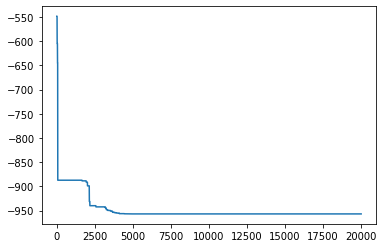

In [12]:
# trajectory: tracks the incumbent from the optimisation trace
### when visualised, should be monotonic decreasing

plt.clf()
plt.plot(trajectory)
plt.show()

In [13]:
# runtime: tracks the cost of evaluating each function evaluation

print("Cost incurred for {} function evaluations in a DE run is {:<.5f} seconds.".format(
    len(runtime), sum(runtime))
)

Cost incurred for 20020 function evaluations in a DE run is 0.30567 seconds.


In [14]:
# history: tracks relevant information from the optimisation trace
### an array of arrays of the format [x, eggholder(x), budget (0 or None)]

print(trajectory[0], history[0])
print(trajectory[12], history[12])
print(trajectory[123], history[123])
print(trajectory[1234], history[1234])

-548.4717264470897 [list([0.41472018678344846, 0.9104776860613233]) -548.4717264470897 0.0]
-548.4717264470897 [list([0.4045278785001656, 0.1702519629762531]) -24.51135595789418 0.0]
-887.2721410403872 [list([0.9504506885323684, 0.561441152174073]) 90.86065403004793 0.0]
-887.2721410403872 [list([0.9525059499863664, 0.5146189749478147]) -368.0219811294849 0.0]


Given DE tracks the _incumbent_ as the best score obtained till any point in the optimisation, the best score can be obtained in the following ways:

In [15]:
print("DE incumbent score from trajectory : {}".format(trajectory[-1]))
print("DE incumbent score from object : {}".format(de.inc_score))
print("DE incumbent sample/configuration from object : {}".format(de.inc_config))

DE incumbent score from trajectory : -956.9182316246659
DE incumbent score from object : -956.9182316246659
DE incumbent sample/configuration from object : [0.97104815 0.9227334 ]


In [16]:
# verifying score for incumbent

print(eggholder_objective(de.inc_config)[0])
print(de.inc_score)

-956.9182316246659
-956.9182316246659


### Comparing with Random Search

We'll reuse the earlier defined function to generate all random samples beforehand. Then evaluate them in order and plot the optimisation trace of the incumbent with that of DE.

In [22]:
# Generating random samples equivalent to number of function evaluations made by DE

samples = random_samples_2d(len(trajectory), bounds)

In [23]:
# Running random search and tracking incumbent

traj_rs = []
inc_score = np.inf
inc_config = None
for i, sample in enumerate(samples):
    fitness = eggholder(sample)
    if fitness < inc_score:
        inc_score = fitness
        inc_config = sample
    traj_rs.append(inc_score)
        
print("Random search done!")
print(inc_config, inc_score, traj_rs[-1])

Random search done!
[509.57684481771923, 401.2493024853634] -949.7386634054069 -949.7386634054069


In [24]:
# verifying

print(inc_config, eggholder(inc_config), traj_rs[-1])

[509.57684481771923, 401.2493024853634] -949.7386634054069 -949.7386634054069


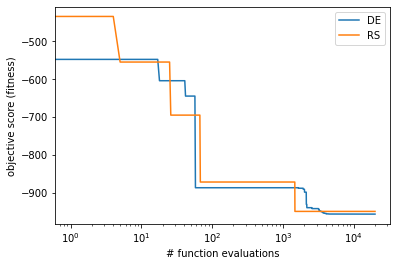

In [25]:
# Plotting DE and Random Search

plt.plot(trajectory, label='DE')
plt.plot(traj_rs, label='RS')
plt.xscale('log')
plt.xlabel('# function evaluations')
plt.ylabel('objective score (fitness)')
plt.legend()
plt.show()

In [26]:
print("RS: {} at {}".format(traj_rs[-1], inc_config))
print("DE: {} at {}".format(de.inc_score, de.inc_config))

RS: -949.7386634054069 at [509.57684481771923, 401.2493024853634]
DE: -956.9182316246659 at [0.97104815 0.9227334 ]
